In [1]:
import sparknlp
from pyspark.ml import PipelineModel, Pipeline
import sparknlp.annotator as sa
import sparknlp.base as sb
import sparknlp
from sparknlp import Finisher

In [2]:
import sys
sys.path.insert(0, '../')
from util import util_data_access

In [3]:
# download data
util_data_access.download_file('newssniffer-nytimes.db.gz', 'edit-pathways/dbs/newssniffer-nytimes.db.gz')
! gunzip newssniffer-nytimes.db.gz

In [ ]:
# util_data_access.download_file('glove-100d-loc.tar.gz', 'spark-nlp/glove-100d-loc.tar.gz')
# ! tar -xzvf glove-100d-loc.tar.gz 

# Load Spark

In [4]:
from pyspark.sql import SparkSession
# spark = sparknlp.start()

spark = (
    SparkSession.builder
      .config("spark.executor.instances", "30")
      .config("spark.driver.memory", "20g")
      .config("spark.executor.memory", "20g")
      .config("spark.executor.cores", "5")
      .config("spark.kryoserializer.buffer.max", "2000M")
      .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.7.5")
      .getOrCreate()
)

In [197]:
# sa.WordEmbeddingsModel.read().load("s3://aspangher/spark-nlp/glove-100d.tmp")

In [9]:
spark

# Load Our Own Data

In [58]:
import sqlite3
import pandas as pd
from tqdm.auto import tqdm
import pyspark.sql.functions as F
# import unidecode

# conn = sqlite3.connect('../data/diffengine-diffs/db/newssniffer-nytimes.db')
conn = sqlite3.connect('newssniffer-nytimes.db')

df = pd.read_sql('''
     SELECT * from entryversion 
     WHERE entry_id IN (SELECT distinct entry_id FROM entryversion LIMIT 5)
 ''', con=conn)

# df = pd.read_sql('''
#     SELECT entry_id, summary, version from entryversion 
# ''', con=conn)

df = df.assign(summary=lambda df: df['summary'].str.replace('</p><p>', ' '))

In [59]:
sdf = spark.createDataFrame(df)

# Try Sentence Tokenizing on Our Own Data

In [288]:
documenter = (
    sb.DocumentAssembler()
    .setInputCol("summary")
    .setOutputCol("document")
            )

sentencer = (sa.SentenceDetector()
                .setInputCols(["document"])
                .setOutputCol("sentences")            
            )

tokenizer = (
    sa.Tokenizer()
        .setInputCols(["sentences"])
        .setOutputCol("token")
)

sent_finisher = (
    Finisher()
    .setInputCols(["sentences"])
    .setIncludeMetadata(True)
)

tok_finisher = (
    Finisher()
    .setInputCols(["token"])
    .setIncludeMetadata(True)
)

zip_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, ARRAYS_ZIP(finished_token, finished_token_metadata) AS zipped_tokens
         FROM __THIS__
    """)
)

explode_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, POSEXPLODE(zipped_tokens) AS (word_idx, zipped_token)
         FROM __THIS__
    """)
)

rename_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, 
                 version,
                 zipped_token.finished_token AS token,
                 zipped_token.finished_token_metadata._2 AS sent_idx,
                 word_idx
         FROM __THIS__
    """)
) 

sd_pipeline = Pipeline(stages=[
    documenter, 
    sentencer, 
    tokenizer, 
    tok_finisher,
    zip_tok,
    explode_tok,
    rename_tok
])

In [289]:
annotations_df = sd_pipeline.fit(sdf).transform(sdf)

In [290]:
annot_dfp = annotations_df.toPandas()

In [292]:
annot_dfp

,entry_id,version,token,sent_idx,word_idx
0,547988,0,In,0,0
1,547988,0,Silicon,0,1
2,547988,0,Valley,0,2
3,547988,0,",",0,3
4,547988,0,Apple,0,4
5,547988,0,just,0,5
6,547988,0,won,0,6
7,547988,0,big,0,7
8,547988,0,against,0,8
9,547988,0,Samsung,0,9


In [162]:
t = (annotations_df
       .withColumn("new", F.arrays_zip('finished_token', 'finished_token_metadata'))
       .withColumn("new", F.explode("new"))
       .select(F.col("new.finished_token").alias("token"), F.col("new.finished_token_metadata._2").alias("sentence"))
    )

In [163]:
t2 = t.limit(5).toPandas()

In [ ]:
sent_list_df = (annotations_df
                .select("entry_id", "version", F.posexplode("finished_sentences"))
                .withColumnRenamed('col', 'sentence')
                .withColumnRenamed('pos', 'sent_idx')
               )
# tdf = sent_list_df.toPandas()

In [54]:
exploded_sent_df = (sent_list_df
 .alias("sent_list_df")
 .join(
     sent_list_df.alias("sent_list_df_2"),
     [F.col("sent_list_df.entry_id") == F.col("sent_list_df_2.entry_id"), 
      F.col("sent_list_df.version") == F.col("sent_list_df_2.version"), 
     ], 
     "inner"
 )
 .select(
     F.col("sent_list_df.entry_id"),
     F.col("sent_list_df.version"),
     F.col("sent_list_df.sent_idx").alias("sent_idx_x"),
     F.col("sent_list_df_2.sent_idx").alias("sent_idx_y"),
     F.col("sent_list_df.sentence").alias("sentence_x"),
     F.col("sent_list_df_2.sentence").alias("sentence_y"),
#    .show(truncate=False)
    )
)

In [55]:
exploded_sent_df.show()


## todo: 
## 0. do this same procedure for diffed sequential versions

## 1a. use tokenize and Albert or BERT or Word2Vec to generate vectors of embeddings for each sentence.
## 1b. lemmatize each sentence

## 2. take Sim_asym along each row, two times using:
## a. phi(x, y) = vec(x) \cdot vec(y)
## b. phi(x ,y) = lemmatization

## 3. for each sentence, select the argmax in both directions.
## 4. choose some reasonable threshold.

## 5. For scores above this threshold, co

+--------+-------+----------+----------+-------------------+--------------------+
|entry_id|version|sent_idx_x|sent_idx_y|         sentence_x|          sentence_y|
+--------+-------+----------+----------+-------------------+--------------------+
|  548743|      1|         0|         0|FORT COLLINS, Colo.| FORT COLLINS, Colo.|
|  548743|      1|         0|         1|FORT COLLINS, Colo.|— Annie Hartnett ...|
|  548743|      1|         0|         2|FORT COLLINS, Colo.|Now 21 and a lead...|
|  548743|      1|         0|         3|FORT COLLINS, Colo.|“I would still sa...|
|  548743|      1|         0|         4|FORT COLLINS, Colo.|“When you’re voti...|
|  548743|      1|         0|         5|FORT COLLINS, Colo.|” So on Saturday ...|
|  548743|      1|         0|         6|FORT COLLINS, Colo.|Each party used t...|
|  548743|      1|         0|         7|FORT COLLINS, Colo.|But Mr. Obama, tr...|
|  548743|      1|         0|         8|FORT COLLINS, Colo.|“I’m counting on ...|
|  548743|      

In [ ]:
chunksize = 10000
unique_entryids = df['entry_id'].unique()
num_chunks = int(unique_entryids.shape[0] / chunksize)

output_dfs = []
for chunk_id in tqdm(range(num_chunks)):
    batch_ids = unique_entryids[chunk_id * chunksize: (chunk_id + 1) * chunksize]
    small_df = df.loc[lambda df: df['entry_id'].isin(batch_ids)]
    #
    sdf = spark.createDataFrame(small_df)
    #
    annotations_df = sd_pipeline.transform(sdf)
    t_df = annotations_df.toPandas()
    output_dfs.append(t_df)

# Get Albert Embeddings

In [ ]:
document_assembler = (
      sb.DocumentAssembler()
        .setInputCol("summary")
        .setOutputCol("document")
)

tokenizer = (
    sa.Tokenizer()
        .setInputCols(["document"])
        .setOutputCol("token")
)
 
word_embeddings = (
    sa.AlbertEmbeddings
        .load('s3://aspangher/spark-nlp/albert_xxlarge_uncased_en')
        .setInputCols(["document", "token"])
        .setOutputCol("embeddings")
)

embeddings_finisher = (
    sb.EmbeddingsFinisher()
            .setInputCols("embeddings")
            .setOutputCols("embeddings_vectors")
            .setOutputAsVector(True)
)

In [367]:
tokenizer = (
    sa.Tokenizer()
        .setInputCols(["document"])
        .setOutputCol("token")
)

bert_pipeline = Pipeline(stages=
  [
    document_assembler,
    tokenizer,
    word_embeddings,
    embeddings_finisher
  ]
)

In [368]:
df_bert = bert_pipeline.fit(sdf).transform(sdf)
# df_bert = bert_pipeline_model.transform(sdf)

In [369]:
t = df_bert.toPandas()

In [ ]:
t2_df = (df_bert
         .select('entry_id', 'version', 'embeddings_vectors')
         .toPandas()
        )

# With Sentences

In [ ]:
# word_embeddings = (
#     sa.WordEmbeddingsModel
#         .load('s3://aspangher/spark-nlp/glove-100d.tmp')
#         .setInputCols("document", "token")
#         .setOutputCol("embeddings")    
# )

In [12]:
from pyspark.ml.feature import Normalizer, SQLTransformer
from pyspark.ml.feature import BucketedRandomProjectionLSH

In [13]:
documenter = (
    sb.DocumentAssembler()
        .setInputCol("summary")
        .setOutputCol("document")
)

sentencer = (
    sa.SentenceDetector()
        .setInputCols(["document"])
        .setOutputCol("sentences")            
)

tokenizer = (
    sa.Tokenizer()
        .setInputCols(["sentences"])
        .setOutputCol("token")
)
 
# word_embeddings = (
#     sa.AlbertEmbeddings
#         .load('s3://aspangher/spark-nlp/albert_large_uncased_en')
#         .setInputCols(["document", "token"])
#         .setOutputCol("embeddings")
# )

# word_embeddings = (
#     sa.WordEmbeddings
#         .load('s3://aspangher/spark-nlp/glove_100d_en_2.4.0')
#         .setInputCols("document", "token")
#         .setOutputCol("embeddings")    
# )

word_embeddings = (
    sa.BertEmbeddings
        .load('s3://aspangher/spark-nlp/small_bert_L4_128_en_2.6.0_2.4')
        .setInputCols(["sentences", "token"])
        .setOutputCol("embeddings")
        .setMaxSentenceLength(512)
        .setBatchSize(100)
)

tok_finisher = (
    Finisher()
    .setInputCols(["token"])
    .setIncludeMetadata(True)
)

embeddings_finisher = (
    sb.EmbeddingsFinisher()
            .setInputCols("embeddings")
            .setOutputCols("embeddings_vectors")
            .setOutputAsVector(True)
)

In [14]:
from scipy.spatial import distance
from pyspark.sql.types import FloatType

In [67]:
zip_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, ARRAYS_ZIP(finished_token, finished_token_metadata, embeddings_vectors) AS zipped_tokens
         FROM __THIS__
    """)
)

explode_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, POSEXPLODE(zipped_tokens) AS (word_idx, zipped_token)
         FROM __THIS__
    """)
)

rename_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, 
                 version,
                 zipped_token.finished_token_metadata._2 AS sent_idx,
                 word_idx,
                 zipped_token.finished_token AS token,
                 zipped_token.embeddings_vectors as word_embedding
         FROM __THIS__
    """)
) 

inner_join = (
    SQLTransformer()
     .setStatement("""
         SELECT word_emb.entry_id as entry_id, 
                 word_emb.version as version,
                 word_emb.sent_idx as sent_idx_x,
                 word_emb_2.sent_idx as sent_idx_y,
                 word_emb.word_idx as word_idx_x,
                 word_emb_2.word_idx as word_idx_y,
                 word_emb.token as token_x,
                 word_emb_2.token as token_y,
                 cosine_distance(word_emb.norm_word_embedding, word_emb_2.norm_word_embedding) as cosine_distance
         FROM __THIS__ word_emb
         JOIN __THIS__ word_emb_2
         ON word_emb.entry_id = word_emb_2.entry_id and
         word_emb.version + 1 = word_emb_2.version
    """)
) 

In [66]:
from scipy.spatial import distance
def cosine_distance(x, y):
    return float(distance.cosine(x, y))

spark.udf.register("cosine_distance", cosine_distance, "float")

<function __main__.cosine_distance(x, y)>

In [21]:
pipeline = Pipeline(stages=
  [
    documenter,
    sentencer,
    tokenizer,
    word_embeddings,
    embeddings_finisher,
    tok_finisher,
    # 
    zip_tok,
    explode_tok,
    rename_tok,
#     vector_normalizer,
    # 
    inner_join,
  ]
)

In [60]:
word_emb_sdf = pipeline.fit(sdf).transform(sdf)

In [23]:
word_emb_sdf.show()

+--------+-------+----------+----------+----------+----------+-------+-----------+--------------------+--------------------+
|entry_id|version|sent_idx_x|sent_idx_y|word_idx_x|word_idx_y|token_x|    token_y|    word_embedding_x|    word_embedding_y|
+--------+-------+----------+----------+----------+----------+-------+-----------+--------------------+--------------------+
|  548743|      0|         0|         0|         0|         0|   FORT|       FORT|[0.01180024570675...|[0.01180024570675...|
|  548743|      0|         0|         0|         0|         1|   FORT|    COLLINS|[0.01180024570675...|[0.00280006408839...|
|  548743|      0|         0|         0|         0|         2|   FORT|          ,|[0.01180024570675...|[0.00304367913983...|
|  548743|      0|         0|         0|         0|         3|   FORT|       Colo|[0.01180024570675...|[0.01396648277347...|
|  548743|      0|         0|         0|         0|         4|   FORT|          .|[0.01180024570675...|[0.00498540722685...|


In [54]:
float(cosine_distance([1,2,3], [2,4,5]))

0.003976158888005288

In [61]:
dot_transformer.transform(word_emb_sdf).show()

+-----------+
|dot_product|
+-----------+
|        0.0|
| 0.41501433|
| 0.43567613|
| 0.47552684|
| 0.41407928|
|  0.5067087|
|  0.5096954|
| 0.42636427|
| 0.41374612|
|  0.4917009|
|  0.6402761|
| 0.52566934|
| 0.53079957|
| 0.58241206|
|  0.5745416|
| 0.49474263|
|  0.5996309|
| 0.47629565|
|  0.5378158|
|  0.5213344|
+-----------+
only showing top 20 rows



In [21]:
t = vector_normalizer.transform(word_emb_sdf).toPandas()

In [17]:
word_emb_sdfp = word_emb_sdf.toPandas()

In [22]:
word_emb_sdfp = t

In [35]:
word_emb_sdfp['join_version'] = word_emb_sdfp['version'] + 1

In [33]:
word_emb_sdfp.iloc[0]['norm_word_embedding'].dot(word_emb_sdfp.iloc[3]['norm_word_embedding'])
#.loc[lambda df: df['entry_id'] == 547988].loc[lambda df: df['version'] == 0]

0.000748996976120793

In [125]:
word_emb_sdfp.head()

,entry_id,version,sent_idx,word_idx,token,word_embedding,norm_word_embedding,join_version
0,547988,0,0,0,In,"[0.5449216365814209, -0.21076048910617828, 0.2...","[0.001921739898593366, -0.0007432753881885494,...",1
1,547988,0,0,1,Silicon,"[0.20658107101917267, 0.47391843795776367, 0.0...","[0.0008927514927824579, 0.002048064669510099, ...",1
2,547988,0,0,2,Valley,"[0.4342455267906189, -0.05810766667127609, -0....","[0.0016800237503699555, -0.0002248089020232907...",1
3,547988,0,0,3,",","[0.2694229483604431, 0.19991809129714966, 0.16...","[0.0011497108088225016, 0.0008531121489176127,...",1
4,547988,0,0,4,Apple,"[0.26225370168685913, -0.34194186329841614, -0...","[0.0012283968796150233, -0.0016016563929651042...",1


In [126]:
inner_join_df = (word_emb_sdfp
 .loc[lambda df: df['entry_id'] == 547989]
 .loc[lambda df: df['version'].isin([0, 1])]
 .pipe(lambda df: df.merge(df, 
                           left_on='join_version',
                           right_on='version'
                          ))
)#.apply(lambda x: x['norm_word_embedding_x'].dot(x['norm_word_embedding_y'], axis=1))

#.loc[lambda df: df['version'] == 0]

In [46]:
from tqdm.auto import tqdm

In [127]:
tqdm.pandas()
inner_join_df['dot_product'] = inner_join_df.progress_apply(lambda x: x['norm_word_embedding_x'].dot(x['norm_word_embedding_y']), axis=1)

  0%|          | 0/366021 [00:00<?, ?it/s]

In [128]:
import numpy as np 
import matplotlib.pyplot as plt 

In [129]:
c, b = np.histogram(inner_join_df['dot_product'], bins=100)

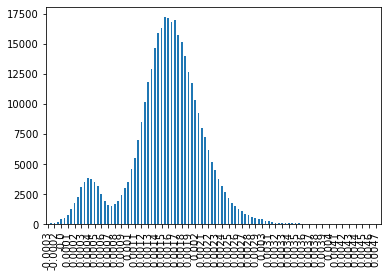

In [130]:
hist_plot = pd.Series({b_i:c_i for c_i, b_i in zip(c, b[:-1])})
hist_plot.plot(kind='bar')
plt.xticks(range(len(hist_plot))[::2], list(map(lambda x: round(x, 4), hist_plot.index))[::2]);

In [131]:
des_col_list = [
    'entry_id_x',
    'version_x',
    'sent_idx_x',
    'word_idx_x',
    'token_x',
    'version_y',
    'sent_idx_y',
    'word_idx_y',
    'token_y',
    'dot_product',
]
inner_join_df.head(2)[des_col_list]

,entry_id_x,version_x,sent_idx_x,word_idx_x,token_x,version_y,sent_idx_y,word_idx_y,token_y,dot_product
0,547989,0,0,0,WASHINGTON,1,0,0,WASHINGTON,0.003068
1,547989,0,0,0,WASHINGTON,1,0,1,—,0.002038


In [133]:
(inner_join_df
 .groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])
 ['dot_product'].idxmax()
 .head(3)
)

entry_id_x  version_x  sent_idx_x  sent_idx_y  word_idx_x  token_x   
547989      0          0           0           0           WASHINGTON       0
                                               1           —              608
                                               2           Weapons       1216
Name: dot_product, dtype: int64

In [134]:
max_words = (inner_join_df
 .loc[lambda df: 
     df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['dot_product'].idxmax()
  ]
 [des_col_list]
)

In [135]:
(max_words.groupby([
     'entry_id_x', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'
 ])['dot_product']
 .mean()
 .reset_index()
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y'])['dot_product'].idxmax()]
 .sort_values('sent_idx_x')
#  .loc[lambda df: df['sent_idx_x'] != df['sent_idx_y']]
)

,entry_id_x,version_x,sent_idx_x,version_y,sent_idx_y,dot_product
0,547989,0,0,1,0,0.003158
21,547989,0,1,1,1,0.003044
42,547989,0,10,1,10,0.003244
63,547989,0,11,1,11,0.003246
84,547989,0,12,1,12,0.003280
105,547989,0,13,1,13,0.003423
126,547989,0,14,1,14,0.002980
147,547989,0,15,1,15,0.003206
168,547989,0,16,1,16,0.003226
189,547989,0,17,1,17,0.003237


In [200]:
embeddings = (
    sa.WordEmbeddings()
    .setStoragePath("/tmp/glove.6B.100d.txt", "TEXT")\
    .setDimension(100)\
    .setStorageRef("glove_100d") \
    .setInputCols("document", "token") \
    .setOutputCol("embeddings")
)

In [202]:
embeddings.fit().transform()

AttributeError: 'WordEmbeddings' object has no attribute 'transform'

In [18]:
len(word_emb_sdfp['token'][0])

2

In [14]:
len(word_emb_sdfp['embeddings'][0])

1570

In [ ]:
from pyspark.sql.types import FloatType
from scipy.spatial import distance

distance_udf = F.udf(lambda x: float(distance.euclidean(x, fixed_entry)), FloatType())
df = df.withColumn('distances', distance_udf(F.col('features')))

In [278]:
wor_emb_sdfp['word_embedding'].isnull().value_counts()

True     4404
False     553
Name: word_embedding, dtype: int64

In [240]:
inner_join = (
    SQLTransformer()
     .setStatement("""
         SELECT word_emb.entry_id, 
                 word_emb.version,
                 word_emb.sentence as sent_idx_x,
                 word_emb_2.sentence as sent_idx_y,
                 word_emb.token as token_x,
                 word_emb_2.token as token_y,
                 word_emb.norm_word_embedding as word_embedding_x,
                 word_emb_2.norm_word_embedding as word_embedding_y
         FROM __THIS__ word_emb
         JOIN __THIS__ word_emb_2
         ON word_emb.entry_id = word_emb_2.entry_id and
         word_emb.version = word_emb_2.version
    """)
) 

In [241]:
inner_join.transform(word_emb_sdf)

DataFrame[entry_id: bigint, version: bigint, sent_idx_x: string, sent_idx_y: string, token_x: string, token_y: string, word_embedding_x: vector, word_embedding_y: vector]

In [16]:
df_bert.show()

+-----+-------+--------------------+--------------------+--------------------+-------+--------+--------------------+------------+--------------------+---------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|version|               title|             created|                 url| source|entry_id|         archive_url|num_versions|             summary|joint_key|      id|            document|           sentences|               token|          embeddings|  embeddings_vectors|
+-----+-------+--------------------+--------------------+--------------------+-------+--------+--------------------+------------+--------------------+---------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|68763|      0|Activist Challeng...|2012-08-26 22:55:...|http://www.nytime...|nytimes|  547988|https://www.newss...|           2|In Silicon Valley...| 547988-0|547988-0|[[docu

In [17]:
dfp = df_bert.toPandas()

In [388]:
t = dfp['embeddings'].iloc[0]

In [389]:
dfp['embeddings_vectors']

0    [[-0.8931788206100464, -0.3664441406726837, -0...
1    [[-0.8931788206100464, -0.3664441406726837, -0...
2    [[0.6029991507530212, -0.002772439271211624, -...
3    [[0.6029991507530212, -0.002772439271211624, -...
4    [[0.6029991507530212, -0.002772439271211624, -...
Name: embeddings_vectors, dtype: object

In [364]:
len(dfp['embeddings_vectors'][0])

1570

In [19]:
dfp[['token', 'embeddings_vectors']]

,token,embeddings_vectors
0,"[(token, 0, 1, In, {'sentence': '0'}, []), (to...","[[-0.8931788206100464, -0.3664441406726837, -0..."
1,"[(token, 0, 1, In, {'sentence': '0'}, []), (to...","[[-0.8931788206100464, -0.3664441406726837, -0..."
2,"[(token, 0, 9, WASHINGTON, {'sentence': '0'}, ...","[[0.6029991507530212, -0.002772439271211624, -..."
3,"[(token, 0, 9, WASHINGTON, {'sentence': '0'}, ...","[[0.6029991507530212, -0.002772439271211624, -..."
4,"[(token, 0, 9, WASHINGTON, {'sentence': '0'}, ...","[[0.6029991507530212, -0.002772439271211624, -..."


In [35]:
dfp['token'][0][0]

Row(annotatorType='token', begin=0, end=1, result='In', metadata={'sentence': '0'}, embeddings=[])

In [36]:
dfp['token'][0][100]

Row(annotatorType='token', begin=529, end=535, result='himself', metadata={'sentence': '2'}, embeddings=[])

In [26]:
len(dfp['embeddings_vectors'][0])

1570

In [32]:
t = dfp['embeddings_vectors'][0][0]

In [ ]:
tokenizer = (
    sa.Tokenizer()
        .setInputCols(["sentences"])
        .setOutputCol("token")
)

word_embeddings = (
    sa.AlbertEmbeddings
        .load('s3://aspangher/spark-nlp/albert_large_uncased_en')
        .setInputCols(["sentences", "token"])
        .setOutputCol("embeddings")
        .setBatchSize(100)
)

embeddings_finisher = (
    sb.EmbeddingsFinisher()
            .setInputCols("embeddings")
            .setOutputCols("embeddings_vectors")
            .setOutputAsVector(True)
)

In [ ]:
(df_bert
 .select('entry_id', 'version', 'sentences', 'embeddings_vectors')
 .write.mode("overwrite").parquet("s3://aspangher/tmp/tmp_albert_embeddings"))

In [ ]:
df_bert.select('entry_id', 'version', 'embeddings_vectors').show()

In [39]:
pipeline_model = bert_pipeline_from_sentences.fit(spark.createDataFrame([[""]]).toDF("summary"))
result = pipeline_model.transform(spark.createDataFrame(pd.DataFrame({"summary": ["I love NLP"]})))

In [ ]:
result.show()

In [ ]:
t2_df = (df_bert
         .select('entry_id', 'version', 'sent_idx', 'sentence', 'embeddings_vectors')
         .toPandas()
        )

# Test Data

In [ ]:
# test_data = CoNLL().readDataset(spark, 's3://aspangher/spark-nlp/conll/eng.train')

In [ ]:
from sparknlp.training import CoNLL
training_data = CoNLL().readDataset(spark, 's3://aspangher/spark-nlp/conll/eng.train')

get_embeddings = (sa.AlbertEmbeddings
        .load('s3://aspangher/spark-nlp/albert_large_uncased_en')
        .setInputCols("sentence", "token")
        .setOutputCol("embeddings")
        .setMaxSentenceLength(100)
        .setBatchSize(8)
)

embeddings_finisher = (
    sb.EmbeddingsFinisher()
        .setInputCols("embeddings")
        .setOutputCols("embeddings_vectors")
        .setOutputAsVector(True)
)

sentence_finisher = (
    Finisher()
       .setInputCols(["sentence"]) 
)

pipeline =  Pipeline(stages=[
    get_embeddings, 
    embeddings_finisher, 
    sentence_finisher
])

pipelineDF = pipeline.fit(training_data).transform(training_data)

(pipelineDF
 .select('finished_sentence', 'embeddings_vectors')
 .write
 .mode("overwrite").parquet('s3://aspangher/tmp/tmp_conll_albert_embeddings.pq')
)

In [29]:
sparknlp.version()

'2.7.5'

In [30]:
spark.version

'2.4.4'

In [ ]:
pipelineDF.select('finished_sentence', 'embeddings_vectors').show()

In [ ]:
ner_pipeline = RecursivePipeline(stages=[
    DocumentAssembler().setInputCol("text").setOutputCol("document"), 
    SentenceDetector().setInputCols(["document"]).setOutputCol("sentence"), 
    Tokenizer().setInputCols(["sentence"]).setOutputCol("token").setMaxLength(100).setSplitChars(["-", "\xa0", "—"]), 
    BertEmbeddings.pretrained(name = "bert_large_cased", lang='en').setInputCols(['sentence', 'token']).setOutputCol('embeddings'), 
#     NerDLModel.pretrained('onto_bert_large_cased', 'en').setInputCols(['sentence', 'token', 'embeddings']).setOutputCol('ner'), 
#     NerConverter().setInputCols(['sentence', 'token', 'ner']).setOutputCol('ner_chunk') 
])

In [ ]:
inner_join = (
    SQLTransformer()
     .setStatement("""
         SELECT word_emb.entry_id as entry_id, 
                 word_emb.version as version,
                 word_emb.sent_idx as sent_idx_x,
                 word_emb_2.sent_idx as sent_idx_y,
                 word_emb.word_idx as word_idx_x,
                 word_emb_2.word_idx as word_idx_y,
                 word_emb.token as token_x,
                 word_emb_2.token as token_y,
                 word_emb.norm_word_embedding as word_embedding_x,
                 word_emb_2.norm_word_embedding as word_embedding_y
         FROM __THIS__ word_emb
         JOIN __THIS__ word_emb_2
         ON word_emb.entry_id = word_emb_2.entry_id and
         word_emb.version + 1 = word_emb_2.version
    """)
) 

cosine_transformer = (
    SQLTransformer()
     .setStatement("""
         SELECT cosine_distance(word_embedding_x, word_embedding_y) as dot_product FROM __THIS__
    """)
)

# vector_normalizer = (
#     Normalizer()
#     .setInputCol("word_embedding")
#     .setOutputCol("norm_word_embedding")
#     .setP(1.0)
# )

# brp = BucketedRandomProjectionLSH(inputCol="norm_word_embedding", outputCol="hashes", bucketLength=1.0)
# inner_join_df.progress_apply(lambda x: x['norm_word_embedding_x'].dot(x['norm_word_embedding_y']), axis=1)